In [1]:
# data reading, processing before join tables

# imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pdb
import pandas as pd
from functools import reduce as rd
from sklearn.decomposition import PCA
%reload_ext autoreload
%autoreload 2

from pyspark.sql.functions import avg, min, max

In [2]:
# set up constants for ease of directory use
FINAL_DIR = 'gs://bigdataprojectbuckets'
DATA_DIR = f'{FINAL_DIR}/data'

In [3]:
# start a spark session
from pyspark.sql import SparkSession

app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

sc = spark.sparkContext

In [4]:
# sc.stop()

In [4]:
# read from google cloud using spark

fdwind = spark.read.csv('gs://bigdataprojectbuckets/training2_fdwind.csv',inferSchema=True,header=True)
fdwindairport = spark.read.csv('gs://bigdataprojectbuckets/training2_fdwindairport.csv',inferSchema=True,header=True)
fdwindaltitude = spark.read.csv('gs://bigdataprojectbuckets/training2_fdwindaltitude.csv',inferSchema=True,header=True)
flighthistory = spark.read.csv('gs://bigdataprojectbuckets/training2_flighthistory.csv',inferSchema=True,header=True)
asdiflightplan = spark.read.csv('gs://bigdataprojectbuckets/training2_asdiflightplan.csv',inferSchema=True,header=True)

In [5]:
fdwind.printSchema()

root
 |-- fbwindairportid: integer (nullable = true)
 |-- ordinal: integer (nullable = true)
 |-- bearing: integer (nullable = true)
 |-- knots: integer (nullable = true)
 |-- temperature: integer (nullable = true)



In [6]:
from pyspark.sql.functions import col, sum

missing_values_count = fdwind.select([sum(col(column).isNull().cast("integer")).alias(column) for column in fdwind.columns])
missing_values_count = missing_values_count.toPandas()
missing_values_count

,fbwindairportid,ordinal,bearing,knots,temperature
0,0,0,0,0,22226


In [7]:
fdwind.describe().toPandas()

,summary,fbwindairportid,ordinal,bearing,knots,temperature
0,count,270723,270723,270723,270723,248497
1,mean,229483.74540028,3.4396227878680423,266.01241859760717,26.758613047284495,-27.026346394523877
2,stddev,10291.085514174132,2.4051620607615654,189.54975667154352,20.339123917879157,24.422557303710434
3,min,211666,0,10,0,-69
4,max,247311,9,990,154,29


<div style="background-color:#f0f0f0; padding:10px;">
<strong>Summary:</strong><br>
There are no NULL values in the columns 'fbwindairportid', 'ordinal', 'bearing', and 'knots'. Missing values exist only in the 'temperature' column, which may result from issues in observation recording. Knowing the mean of all temperature values, we have decided to replace the NULL values with this mean for further analysis.
</div>

In [8]:
fdwindairport.printSchema()

root
 |-- fbwindairportid: integer (nullable = true)
 |-- fbwindreportid: integer (nullable = true)
 |-- airportcode: string (nullable = true)



In [9]:
missing_values_count_1 = fdwindairport.select([sum(col(column).isNull().cast("integer")).alias(column) for column in fdwindairport.columns])
missing_values_count_1 = missing_values_count_1.toPandas()
missing_values_count_1

,fbwindairportid,fbwindreportid,airportcode
0,0,0,0


In [10]:
fdwindairport.describe().toPandas()

,summary,fbwindairportid,fbwindreportid,airportcode
0,count,35646,35646,35646
1,mean,229488.5,2853.8625091174326,None
2,stddev,10290.258184322,126.22468163039072,None
3,min,211666,2632,2XG
4,max,247311,3071,ZUN


<div style="background-color:#f0f0f0; padding:10px;">
<strong>Summary:</strong><br>
The 'fdwindairport' table has 3 columns, and no missing values were detected, which is great!
</div>

In [11]:
fdwindaltitude.printSchema()

root
 |-- fbwindreportid: integer (nullable = true)
 |-- ordinal: integer (nullable = true)
 |-- altitude: integer (nullable = true)



In [12]:
missing_values_count_2 = fdwindaltitude.select([sum(col(column).isNull().cast("integer")).alias(column) for column in fdwindaltitude.columns])
missing_values_count_2 = missing_values_count_2.toPandas()
missing_values_count_2

,fbwindreportid,ordinal,altitude
0,0,0,0


In [17]:
fdwindaltitude.describe().toPandas()

,summary,fbwindreportid,ordinal,altitude
0,count,3870,3870,3870
1,mean,2851.1501291989666,4.02015503875969,17279.328165374678
2,stddev,127.14545551589654,2.6995891968470778,13682.584409244842
3,min,2632,0,1000
4,max,3071,9,53000


<div style="background-color:#f0f0f0; padding:10px;">
<strong>Summary:</strong><br>
The 'fdwindaltitude' table has 3 columns, and no missing values were detected, which is great!
</div>

In [18]:
flighthistory.printSchema()

root
 |-- id: integer (nullable = true)
 |-- airline_code: string (nullable = true)
 |-- airline_icao_code: string (nullable = true)
 |-- flight_number: integer (nullable = true)
 |-- departure_airport_code: string (nullable = true)
 |-- departure_airport_icao_code: string (nullable = true)
 |-- arrival_airport_code: string (nullable = true)
 |-- arrival_airport_icao_code: string (nullable = true)
 |-- published_departure: string (nullable = true)
 |-- published_arrival: string (nullable = true)
 |-- scheduled_gate_departure: string (nullable = true)
 |-- actual_gate_departure: string (nullable = true)
 |-- scheduled_gate_arrival: string (nullable = true)
 |-- actual_gate_arrival: string (nullable = true)
 |-- scheduled_runway_departure: string (nullable = true)
 |-- actual_runway_departure: string (nullable = true)
 |-- scheduled_runway_arrival: string (nullable = true)
 |-- actual_runway_arrival: string (nullable = true)
 |-- creator_code: string (nullable = true)
 |-- scheduled_air_

In [19]:
missing_values_count_3 = flighthistory.select([sum(col(column).isNull().cast("integer")).alias(column) for column in flighthistory.columns])
missing_values_count_3 = missing_values_count_3.toPandas()
missing_values_count_3

,id,airline_code,airline_icao_code,flight_number,departure_airport_code,departure_airport_icao_code,arrival_airport_code,arrival_airport_icao_code,published_departure,published_arrival,...,scheduled_runway_arrival,actual_runway_arrival,creator_code,scheduled_air_time,scheduled_block_time,departure_airport_timezone_offset,arrival_airport_timezone_offset,scheduled_aircraft_type,actual_aircraft_type,icao_aircraft_type_actual
0,0,0,1512,0,0,0,0,0,100259,100259,...,31382,51211,0,31382,91194,0,0,100259,711576,62652


In [20]:
flighthistory.describe().toPandas()

,summary,id,airline_code,airline_icao_code,flight_number,departure_airport_code,departure_airport_icao_code,arrival_airport_code,arrival_airport_icao_code,published_departure,...,scheduled_runway_arrival,actual_runway_arrival,creator_code,scheduled_air_time,scheduled_block_time,departure_airport_timezone_offset,arrival_airport_timezone_offset,scheduled_aircraft_type,actual_aircraft_type,icao_aircraft_type_actual
0,count,711576,711576,710064,711576,711576,711576,711576,711576,611317,...,680194,660365,711576,680194,620382,711576,711576,611317,0,648924
1,mean,3.072983116636185E8,None,None,2589.9427861535523,None,None,None,None,None,...,None,None,None,94.44022440656636,129.125506542743,-4.9947187651073115,-4.998542671478521,541.6872984125268,None,None
2,stddev,809621.9702907128,None,None,2073.3864941937923,None,None,None,None,None,...,None,None,None,61.16069340888028,95.90125519272513,1.1281392217587365,1.1286867870501252,210.3955832719113,None,None
3,min,305796740,1I,AAH,1,AAF,KAAF,AAF,KAAF,2013-08-14 09:00:00+00,...,2013-08-14 09:22:00+00,2013-08-14 08:47:00+00,A,-65,1,-7,-7,319,None,A124
4,max,308963256,ZW,XOJ,9999,ZZV,KZZV,ZZV,KZZV,2013-09-11 08:41:00+00,...,2013-09-11 12:15:00+00,2013-09-11 14:07:00+00,I,1422,1670,-4,-4,SH6,None,WB57


<div style="background-color:#f0f0f0; padding:10px;">
<strong>Summary:</strong><br>
The 'flighthistory' table includes various columns related to flight information, such as identifiers, codes, and timestamps, among others. Missing values are present in the columns 'airline_icao_code', 'published_departure', 'published_arrival', 'scheduled_runway_arrival', 'actual_runway_arrival', 'scheduled_air_time', 'scheduled_block_time', 'scheduled_aircraft_type', 'actual_aircraft_type', and 'icao_aircraft_type_actual'. After reviewing these missing values, we concluded that they cannot be rectified; thus, we decided to remove the rows with these NAs. However, since the <strong>'actual_aircraft_type'</strong> column lacks any values, we will need to drop this column entirely.
</div>

In [21]:
asdiflightplan.printSchema()

root
 |-- id: integer (nullable = true)
 |-- update_time_utc: string (nullable = true)
 |-- flighthistory_id: integer (nullable = true)
 |-- departure_airport: string (nullable = true)
 |-- arrival_airport: string (nullable = true)
 |-- aircraft_id: string (nullable = true)
 |-- legacy_route: string (nullable = true)
 |-- original_departure_utc: string (nullable = true)
 |-- estimated_departure_utc: string (nullable = true)
 |-- original_arrival_utc: string (nullable = true)
 |-- estimated_arrival_utc: string (nullable = true)



In [22]:
missing_values_count_4 = asdiflightplan.select([sum(col(column).isNull().cast("integer")).alias(column) for column in asdiflightplan.columns])
missing_values_count_4 = missing_values_count_4.toPandas()
missing_values_count_4

,id,update_time_utc,flighthistory_id,departure_airport,arrival_airport,aircraft_id,legacy_route,original_departure_utc,estimated_departure_utc,original_arrival_utc,estimated_arrival_utc
0,0,0,0,193,1,0,0,0,0,0,0


In [23]:
asdiflightplan.describe().toPandas()

,summary,id,update_time_utc,flighthistory_id,departure_airport,arrival_airport,aircraft_id,legacy_route,original_departure_utc,estimated_departure_utc,original_arrival_utc,estimated_arrival_utc
0,count,7954958,7954958,7954958,7954765,7954957,7954958,7954958,7954958,7954958,7954958,7954958
1,mean,1.2202349433752649E8,None,3.0730841514516985E8,None,21.0,None,None,None,None,None,None
2,stddev,7150581.1692793695,None,793899.6939766831,None,0.0,None,None,None,None,None,None
3,min,114132776,2013-08-14 16:00:01+00,305796740,07FA,07FA,AAH320,07FA..DHP..KMIA/0008,1970-01-01 01:00:00+00,2013-08-13 22:08:00+00,1970-01-01 01:00:00+00,2013-08-14 03:37:00+00
4,max,136407537,2013-09-11 20:35:39+00,308963256,ZSPD,ZZV,XOJ795,ZSPD.LAM22D.LAMEN.A593.SADLI.A593.POTET.A593.F...,2013-09-11 11:49:00+00,2013-09-11 12:50:00+00,2013-09-11 12:35:00+00,2013-09-11 14:03:00+00


<div style="background-color:#f0f0f0; padding:10px;">
<strong>Summary:</strong><br>
The 'asdiflightplan' table contains records for 7,954,958 flights, as indicated by the counts for 'id', 'update_time_utc', 'flighthistory_id', among other columns. Missing values are present in the 'departure_airport' and 'arrival_airport' columns. As these missing values cannot be remedied, we have decided to remove the rows containing these NAs.
</div>

# Join tables

## 1. fdwind_all.csv

1. outer join ( training2_fdwindaltitude.csv & training2_fdwindairport.csv ) with column “fbwindreportid”
2. outer join ( 1 & training2_fdwind.csv ) with column “fbwindairportid”, “ordinal”

Column names: (8 columns)  
fbwindairportid, fbwindreportid, ordinal, airportcode, altitude, bearing, knots, temperature


In [24]:
# 1. outer join ( training2_fdwindaltitude.csv & training2_fdwindairport.csv ) with column “fbwindreportid”

fdwind_al_ap = fdwindaltitude.join(fdwindairport, 'fbwindreportid', 'outer')
fdwind_al_ap.printSchema()

root
 |-- fbwindreportid: integer (nullable = true)
 |-- ordinal: integer (nullable = true)
 |-- altitude: integer (nullable = true)
 |-- fbwindairportid: integer (nullable = true)
 |-- airportcode: string (nullable = true)



In [25]:
# 2. outer join ( 1 & training2_fdwind.csv ) with column “fbwindairportid”, “ordinal”
# AND drop two id columns that will not be used later

fdwind_all = fdwind_al_ap.join(fdwind, ['fbwindairportid', 'ordinal'], 'outer')\
                            .drop('fbwindairportid','fbwindreportid')
fdwind_all.printSchema()

root
 |-- ordinal: integer (nullable = true)
 |-- altitude: integer (nullable = true)
 |-- airportcode: string (nullable = true)
 |-- bearing: integer (nullable = true)
 |-- knots: integer (nullable = true)
 |-- temperature: integer (nullable = true)



In [26]:
# Data processing: Aggregate 
# Steps:
# 1. group by airportcode
# 2. calculate average altitude, bearing, knots, temperature [ignore null value]

fdwind_all_agg = fdwind_all.groupBy('airportcode')\
                            .agg(avg('altitude').alias('avg_altitude'),\
                                 avg('bearing').alias('avg_bearing'),\
                                 avg('knots').alias('avg_knots'),\
                                 avg('temperature').alias('avg_temperature'),\
                                 min('altitude').alias('min_altitude'),\
                                 min('bearing').alias('min_bearing'),\
                                 min('knots').alias('min_knots'),\
                                 min('temperature').alias('min_temperature'),\
                                 max('altitude').alias('max_altitude'),\
                                 max('bearing').alias('max_bearing'),\
                                 max('knots').alias('max_knots'),\
                                 max('temperature').alias('max_temperature'))

In [27]:
# there are total 403 airport code

#fdwind_all_agg.count() 

In [28]:
# Those two line is to check how spark handle null value in the groupBy

#fdwind_all_agg.where(fdwind_all_agg.airportcode=='PNI').show()
#fdwind_all_agg.where(fdwind_all_agg.airportcode=='BFF').show()

In [29]:
# to cache fdwind_all in rdd for later join

#fdwind_all_rdd = fdwind_all.cache()
fdwind_all_agg_rdd = fdwind_all_agg.cache()

## 2. asdi_flighthistory.csv:

outer join ( training2_flighthistory.csv & training2_asdiflightplan.csv )
    with column “id” == “flighthistory_id”


In [30]:
# outer join ( training2_flighthistory.csv & training2_asdiflightplan.csv ) with column “flighthistory_id”

# Drop columns in flighthistory:
# 1. For useless columns: flighthistory_id, id, actual_aircraft_type(cuz missing all)
# 2. For columns that are duplicate: airline_icao_code, departure_airport_icao_code,
#           arrival_airport_icao_code,
# 3. Columns that are not similar to published departure/arrival time:
#           scheduled_gate_departure, actual_gate_departure,
#           scheduled_gate_arrival, actual_gate_arrival,
#           scheduled_runway_departure, actual_runway_departure,
#           scheduled_runway_arrival, actual_runway_arrival,
# 4. Others not important columns:
#           departure_airport_timezone_offset, arrival_airport_timezone_offset,          

# Drop other columns in asdiflightplan:
# 1. useless: update_time_utc

asdi_flighthistory = flighthistory.withColumnRenamed('id','flighthistory_id').join(asdiflightplan, 'flighthistory_id', 'outer')\
                                    .drop('flighthistory_id', 'id', 
                                          'actual_aircraft_type',
                                          'airline_icao_code', 'departure_airport_icao_code', 'arrival_airport_icao_code',
                                          'scheduled_gate_departure', 'actual_gate_departure',
                                          'scheduled_gate_arrival', 'actual_gate_arrival',
                                          'scheduled_runway_departure', 'actual_runway_departure',
                                          'scheduled_runway_arrival', 'actual_runway_arrival',
                                          'departure_airport_timezone_offset', 'arrival_airport_timezone_offset',
                                          'update_time_utc',
                                          'estimated_departure_utc', 'estimated_arrival_utc' # those two are not for sure to drop
                                         )
asdi_flighthistory.printSchema()

#flighthistory.count() # 711576
#asdiflightplan.count() # 7954958
#asdi_flighthistory.count() # 8034562

root
 |-- airline_code: string (nullable = true)
 |-- flight_number: integer (nullable = true)
 |-- departure_airport_code: string (nullable = true)
 |-- arrival_airport_code: string (nullable = true)
 |-- published_departure: string (nullable = true)
 |-- published_arrival: string (nullable = true)
 |-- creator_code: string (nullable = true)
 |-- scheduled_air_time: integer (nullable = true)
 |-- scheduled_block_time: integer (nullable = true)
 |-- scheduled_aircraft_type: string (nullable = true)
 |-- icao_aircraft_type_actual: string (nullable = true)
 |-- departure_airport: string (nullable = true)
 |-- arrival_airport: string (nullable = true)
 |-- aircraft_id: string (nullable = true)
 |-- legacy_route: string (nullable = true)
 |-- original_departure_utc: string (nullable = true)
 |-- original_arrival_utc: string (nullable = true)



In [28]:
# pyspark dataframe after join and drop

#asdi_flighthistory.show()

In [31]:
# In case after we drop some column, there is duplicates in the data

asdi_fh_unique = asdi_flighthistory.dropDuplicates()
#asdi_fh_unique.count() # 3240421

In [32]:
# cache as rdd

#asdi_flighthistory_rdd = asdi_flighthistory.cache()
asdi_fh_unique_rdd = asdi_fh_unique.cache() # we should use data that has no duplicate 

## 3. fdwind_asdi_final.csv:

1. outer join ( fdwind_all.csv & asdi_flighthistory.csv ) with column “airportcode” == “arrival_airport_code”   
(remember to rename the columns in fdwind_all.csv to show it is for arrival airport)

2. outer join ( fdwind_all.csv & 1 ) with column “airportcode” == “departure_airport_code”   
(remember to rename the columns in fdwind_all.csv to show it is for departure airport)


In [33]:
fdwind_all_agg_rdd.printSchema()

root
 |-- airportcode: string (nullable = true)
 |-- avg_altitude: double (nullable = true)
 |-- avg_bearing: double (nullable = true)
 |-- avg_knots: double (nullable = true)
 |-- avg_temperature: double (nullable = true)
 |-- min_altitude: integer (nullable = true)
 |-- min_bearing: integer (nullable = true)
 |-- min_knots: integer (nullable = true)
 |-- min_temperature: integer (nullable = true)
 |-- max_altitude: integer (nullable = true)
 |-- max_bearing: integer (nullable = true)
 |-- max_knots: integer (nullable = true)
 |-- max_temperature: integer (nullable = true)



In [34]:
asdi_fh_unique_rdd.printSchema()

root
 |-- airline_code: string (nullable = true)
 |-- flight_number: integer (nullable = true)
 |-- departure_airport_code: string (nullable = true)
 |-- arrival_airport_code: string (nullable = true)
 |-- published_departure: string (nullable = true)
 |-- published_arrival: string (nullable = true)
 |-- creator_code: string (nullable = true)
 |-- scheduled_air_time: integer (nullable = true)
 |-- scheduled_block_time: integer (nullable = true)
 |-- scheduled_aircraft_type: string (nullable = true)
 |-- icao_aircraft_type_actual: string (nullable = true)
 |-- departure_airport: string (nullable = true)
 |-- arrival_airport: string (nullable = true)
 |-- aircraft_id: string (nullable = true)
 |-- legacy_route: string (nullable = true)
 |-- original_departure_utc: string (nullable = true)
 |-- original_arrival_utc: string (nullable = true)



In [35]:
# TODO-Join: This will help us get the final data
## For arrival airport:
# 1. fdwind: rename airportcode to arrival_airport_code
# 2. fdwind: rename all the rest column names with arrival in it
# 3. join with asdi_fh with arrival_airport_code
## For departure airport:
# 1. fdwind: rename airportcode to departure_airport_code
# 2. fdwind: rename all the rest column names with departure in it
# 3. join with asdi_fh with departure_airport_code


# 1. outer join ( fdwind_all.csv & asdi_flighthistory.csv ) with column “airportcode” == “arrival_airport_code”

fdwind_asdi_arrival = fdwind_all_agg_rdd\
    .withColumnRenamed('airportcode','arrival_airport_code')\
    .withColumnRenamed('avg_altitude','arrival_airport_avg_altitude')\
    .withColumnRenamed('avg_bearing','arrival_airport_avg_bearing')\
    .withColumnRenamed('avg_knots','arrival_airport_avg_knots')\
    .withColumnRenamed('avg_temperature','arrival_airport_avg_temperature')\
    .withColumnRenamed('min_altitude','arrival_airport_min_altitude')\
    .withColumnRenamed('min_bearing','arrival_airport_min_bearing')\
    .withColumnRenamed('min_knots','arrival_airport_min_knots')\
    .withColumnRenamed('min_temperature','arrival_airport_min_temperature')\
    .withColumnRenamed('max_altitude','arrival_airport_max_altitude')\
    .withColumnRenamed('max_bearing','arrival_airport_max_bearing')\
    .withColumnRenamed('max_knots','arrival_airport_max_knots')\
    .withColumnRenamed('max_temperature','arrival_airport_max_temperature')\
    .join(asdi_fh_unique_rdd, 
          'arrival_airport_code',
          'outer')
fdwind_asdi_arrival.printSchema()

root
 |-- arrival_airport_code: string (nullable = true)
 |-- arrival_airport_avg_altitude: double (nullable = true)
 |-- arrival_airport_avg_bearing: double (nullable = true)
 |-- arrival_airport_avg_knots: double (nullable = true)
 |-- arrival_airport_avg_temperature: double (nullable = true)
 |-- arrival_airport_min_altitude: integer (nullable = true)
 |-- arrival_airport_min_bearing: integer (nullable = true)
 |-- arrival_airport_min_knots: integer (nullable = true)
 |-- arrival_airport_min_temperature: integer (nullable = true)
 |-- arrival_airport_max_altitude: integer (nullable = true)
 |-- arrival_airport_max_bearing: integer (nullable = true)
 |-- arrival_airport_max_knots: integer (nullable = true)
 |-- arrival_airport_max_temperature: integer (nullable = true)
 |-- airline_code: string (nullable = true)
 |-- flight_number: integer (nullable = true)
 |-- departure_airport_code: string (nullable = true)
 |-- published_departure: string (nullable = true)
 |-- published_arrival:

In [36]:
#fdwind_asdi_arrival.count() #3240678 Now it is much lesser, and the useful information is denser

# The original output without limit the columns we need has 3001895001 rows, which is too many.
# Solution:
#    We would like to go back to the pyspark dataframe fdwind_all, and asdi_flighthistory
#    to choose columns that we think we really need it to predict the flight delay. 

In [37]:
# 2. outer join ( fdwind_all.csv & 1 ) with column “airportcode” == “departure_airport_code”  

fdwind_asdi_final = fdwind_all_agg_rdd\
    .withColumnRenamed('airportcode','departure_airport_code')\
    .withColumnRenamed('avg_altitude','departure_airport_avg_altitude')\
    .withColumnRenamed('avg_bearing','departure_airport_avg_bearing')\
    .withColumnRenamed('avg_knots','departure_airport_avg_knots')\
    .withColumnRenamed('avg_temperature','departure_airport_avg_temperature')\
    .withColumnRenamed('min_altitude','departure_airport_min_altitude')\
    .withColumnRenamed('min_bearing','departure_airport_min_bearing')\
    .withColumnRenamed('min_knots','departure_airport_min_knots')\
    .withColumnRenamed('min_temperature','departure_airport_min_temperature')\
    .withColumnRenamed('max_altitude','departure_airport_max_altitude')\
    .withColumnRenamed('max_bearing','departure_airport_max_bearing')\
    .withColumnRenamed('max_knots','departure_airport_max_knots')\
    .withColumnRenamed('max_temperature','departure_airport_max_temperature')\
    .join(fdwind_asdi_arrival, 
          'departure_airport_code',
          'outer')
fdwind_asdi_final.printSchema()

root
 |-- departure_airport_code: string (nullable = true)
 |-- departure_airport_avg_altitude: double (nullable = true)
 |-- departure_airport_avg_bearing: double (nullable = true)
 |-- departure_airport_avg_knots: double (nullable = true)
 |-- departure_airport_avg_temperature: double (nullable = true)
 |-- departure_airport_min_altitude: integer (nullable = true)
 |-- departure_airport_min_bearing: integer (nullable = true)
 |-- departure_airport_min_knots: integer (nullable = true)
 |-- departure_airport_min_temperature: integer (nullable = true)
 |-- departure_airport_max_altitude: integer (nullable = true)
 |-- departure_airport_max_bearing: integer (nullable = true)
 |-- departure_airport_max_knots: integer (nullable = true)
 |-- departure_airport_max_temperature: integer (nullable = true)
 |-- arrival_airport_code: string (nullable = true)
 |-- arrival_airport_avg_altitude: double (nullable = true)
 |-- arrival_airport_avg_bearing: double (nullable = true)
 |-- arrival_airport_

In [38]:
#fdwind_asdi_final.count() # the number of rows are 3240934

## 4. flight_full.csv

In this dataset, we only keep those records that are having both published_arrival and original_arrival_utc.   
*published_arrival: represent the official/actuall arrival time*  
*original_arrival_utc: represent the original time that the flight is been scheduled*  

The reason is that we want to use those two columns to help us decide whether the flight is delayed or not.  
Either of them missing will not helping us to label whether the flight is delayed so we would like to filter out:  
1. Rows that has "published_arrival" missing;  
2. Rows that has "original_arrival_utc" missing.

In [39]:
flight = fdwind_asdi_final.filter(fdwind_asdi_final['published_arrival'].isNotNull() | fdwind_asdi_final['original_arrival_utc'].isNotNull())

In [100]:
#flight.count() # There are 3228608, so we filtered out about 12000 rows

In [101]:
#flight.show()

# Data Engineering

## 1. column name: delay

If original_arrival_utc < published_arrival, label it as 1 (delayed).  
Otherwise, label it as 0 (not delayed).

In [40]:
flight.printSchema()

root
 |-- departure_airport_code: string (nullable = true)
 |-- departure_airport_avg_altitude: double (nullable = true)
 |-- departure_airport_avg_bearing: double (nullable = true)
 |-- departure_airport_avg_knots: double (nullable = true)
 |-- departure_airport_avg_temperature: double (nullable = true)
 |-- departure_airport_min_altitude: integer (nullable = true)
 |-- departure_airport_min_bearing: integer (nullable = true)
 |-- departure_airport_min_knots: integer (nullable = true)
 |-- departure_airport_min_temperature: integer (nullable = true)
 |-- departure_airport_max_altitude: integer (nullable = true)
 |-- departure_airport_max_bearing: integer (nullable = true)
 |-- departure_airport_max_knots: integer (nullable = true)
 |-- departure_airport_max_temperature: integer (nullable = true)
 |-- arrival_airport_code: string (nullable = true)
 |-- arrival_airport_avg_altitude: double (nullable = true)
 |-- arrival_airport_avg_bearing: double (nullable = true)
 |-- arrival_airport_

In [41]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import TimestampType

flight = flight.withColumn("published_departure_timestamp", to_timestamp(flight["published_departure"], "yyyy-MM-dd HH:mm:ss"))
flight = flight.withColumn("published_arrival_timestamp", to_timestamp(flight["published_arrival"], "yyyy-MM-dd HH:mm:ss"))
flight = flight.withColumn("original_departure_utc_timestamp", to_timestamp(flight["original_departure_utc"], "yyyy-MM-dd HH:mm:ss"))
flight = flight.withColumn("original_arrival_timestamp", to_timestamp(flight["original_arrival_utc"], "yyyy-MM-dd HH:mm:ss"))

In [42]:
flight = flight.drop("published_departure", "published_arrival", "original_departure_utc", "original_arrival_utc")

In [43]:
#flight.show()

In [44]:
missing_values_count = flight.select([sum(col(column).isNull().cast("integer")).alias(column) for column in flight.columns])
missing_values_count = missing_values_count.toPandas()
missing_values_count

,departure_airport_code,departure_airport_avg_altitude,departure_airport_avg_bearing,departure_airport_avg_knots,departure_airport_avg_temperature,departure_airport_min_altitude,departure_airport_min_bearing,departure_airport_min_knots,departure_airport_min_temperature,departure_airport_max_altitude,...,scheduled_aircraft_type,icao_aircraft_type_actual,departure_airport,arrival_airport,aircraft_id,legacy_route,published_departure_timestamp,published_arrival_timestamp,original_departure_utc_timestamp,original_arrival_timestamp
0,0,1703264,1703264,1703264,1703264,1703264,1703264,1703264,1703264,1703264,...,267554,81774,58304,58231,58230,58230,267554,267554,58230,58230


In [45]:
flight = flight.dropna()

In [46]:
flight.describe().toPandas()

,summary,departure_airport_code,departure_airport_avg_altitude,departure_airport_avg_bearing,departure_airport_avg_knots,departure_airport_avg_temperature,departure_airport_min_altitude,departure_airport_min_bearing,departure_airport_min_knots,departure_airport_min_temperature,...,flight_number,creator_code,scheduled_air_time,scheduled_block_time,scheduled_aircraft_type,icao_aircraft_type_actual,departure_airport,arrival_airport,aircraft_id,legacy_route
0,count,645365,645365,645365,645365,645365,645365,645365,645365,645365,...,645365,645365,645365,645365,645365,645365,645365,645365,645365,645365
1,mean,None,19444.44444444579,276.0608467132984,21.3049214093725,-16.16996603495678,3000.0,10.19023343379328,0.0,-57.878998706158534,...,2207.29172018935,None,117.878233247852,143.09787794503885,575.9786679369479,None,None,None,None,None
2,stddev,None,0.0,31.495077899095463,6.086998264611309,1.9824374560957598,0.0,2.9744453238471724,0.0,2.0855537730160703,...,1922.1569276852904,None,73.24254228249046,77.62412412371039,207.2592442218241,None,None,None,None,None
3,min,ABQ,19444.444444444445,166.62921348314606,12.656679151061173,-24.363295880149813,3000,10,0,-62,...,1,I,18,36,319,A319,ABQ,1H2,AAL1003,3516N/09520W./.3516N/9520W..RMG.KOLTT1.ATL
4,max,YKM,19444.444444444445,340.80056179775283,34.31601123595506,-12.547752808988765,3000,70,0,-54,...,8812,I,383,400,SH6,SH36,ZBAA,YKM,VRD969,ZBAA./.YYJ.MARNR3.KSEA


In [47]:
from pyspark.sql.functions import unix_timestamp, col, when

# Calculate the time difference in seconds
flight = flight.withColumn(
    "time_difference_seconds",
    (unix_timestamp("published_arrival_timestamp") - unix_timestamp("original_arrival_timestamp"))
)

# Check if delay for more than 1 min, if yes, return 1, if no, return 0
flight = flight.withColumn(
    "is_greater_than_1_minutes",
    when(col("time_difference_seconds") > (1 * 60), 1).otherwise(0)
)

flight.select("published_arrival_timestamp", "original_arrival_timestamp", "is_greater_than_1_minutes").show()

+---------------------------+--------------------------+-------------------------+
|published_arrival_timestamp|original_arrival_timestamp|is_greater_than_1_minutes|
+---------------------------+--------------------------+-------------------------+
|        2013-08-14 22:55:00|       2013-08-14 22:55:00|                        0|
|        2013-08-15 15:04:00|       2013-08-15 15:04:00|                        0|
|        2013-08-16 23:14:00|       2013-08-16 23:14:00|                        0|
|        2013-08-19 22:01:00|       2013-08-19 22:01:00|                        0|
|        2013-08-19 22:26:00|       2013-08-19 22:26:00|                        0|
|        2013-08-20 23:58:00|       2013-08-20 23:58:00|                        0|
|        2013-08-21 03:50:00|       2013-08-21 03:50:00|                        0|
|        2013-08-21 16:54:00|       2013-08-21 16:24:00|                        1|
|        2013-08-21 20:31:00|       2013-08-21 20:31:00|                        0|
|   

In [48]:
flight.printSchema()

root
 |-- departure_airport_code: string (nullable = true)
 |-- departure_airport_avg_altitude: double (nullable = true)
 |-- departure_airport_avg_bearing: double (nullable = true)
 |-- departure_airport_avg_knots: double (nullable = true)
 |-- departure_airport_avg_temperature: double (nullable = true)
 |-- departure_airport_min_altitude: integer (nullable = true)
 |-- departure_airport_min_bearing: integer (nullable = true)
 |-- departure_airport_min_knots: integer (nullable = true)
 |-- departure_airport_min_temperature: integer (nullable = true)
 |-- departure_airport_max_altitude: integer (nullable = true)
 |-- departure_airport_max_bearing: integer (nullable = true)
 |-- departure_airport_max_knots: integer (nullable = true)
 |-- departure_airport_max_temperature: integer (nullable = true)
 |-- arrival_airport_code: string (nullable = true)
 |-- arrival_airport_avg_altitude: double (nullable = true)
 |-- arrival_airport_avg_bearing: double (nullable = true)
 |-- arrival_airport_

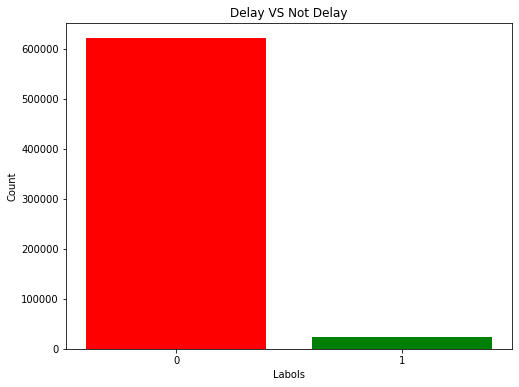

In [49]:
import matplotlib.pyplot as plt

# Aggregate the data to count
counts = flight.groupBy('is_greater_than_1_minutes').count()

# Convert to a Pandas DataFrame
counts_pandas = counts.toPandas()
counts_pandas.sort_values('is_greater_than_1_minutes', inplace=True)

# Plotting the bar plot
plt.figure(figsize=(8, 6))
plt.bar(counts_pandas['is_greater_than_1_minutes'].astype(str), counts_pandas['count'], color=['red', 'green'])
plt.xlabel('Labols')
plt.ylabel('Count')
plt.title('Delay VS Not Delay')
plt.xticks([str(x) for x in counts_pandas['is_greater_than_1_minutes'].unique()])
plt.show()

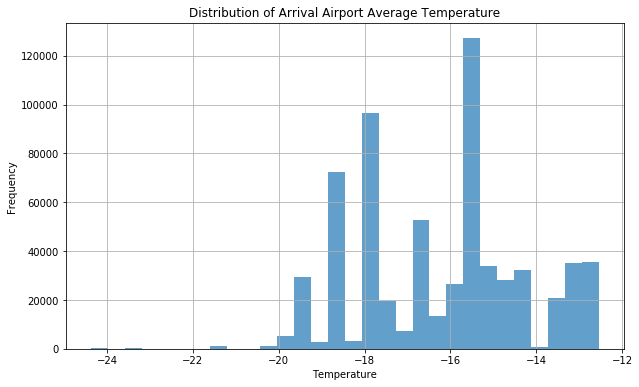

In [50]:
# Convert to a Pandas DataFrame
pandas_df = flight.select("arrival_airport_avg_temperature").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(pandas_df['arrival_airport_avg_temperature'], bins=30, alpha=0.7)
plt.title('Distribution of Arrival Airport Average Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

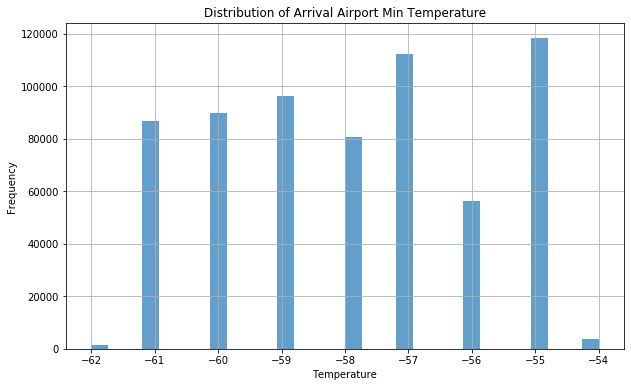

In [51]:
# Convert to a Pandas DataFrame
pandas_df = flight.select("arrival_airport_min_temperature").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(pandas_df['arrival_airport_min_temperature'], bins=30, alpha=0.7)
plt.title('Distribution of Arrival Airport Min Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

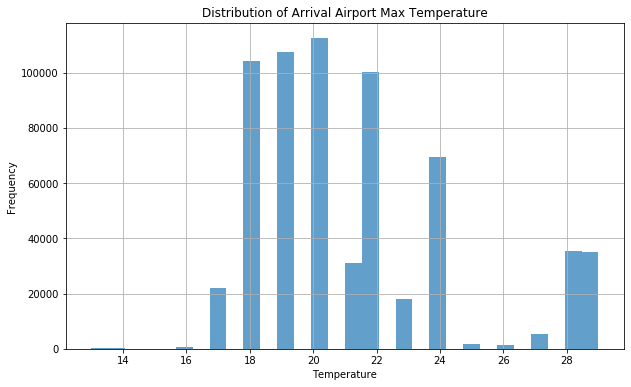

In [52]:
# Convert to a Pandas DataFrame
pandas_df = flight.select("arrival_airport_max_temperature").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(pandas_df['arrival_airport_max_temperature'], bins=30, alpha=0.7)
plt.title('Distribution of Arrival Airport Max Temperature')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

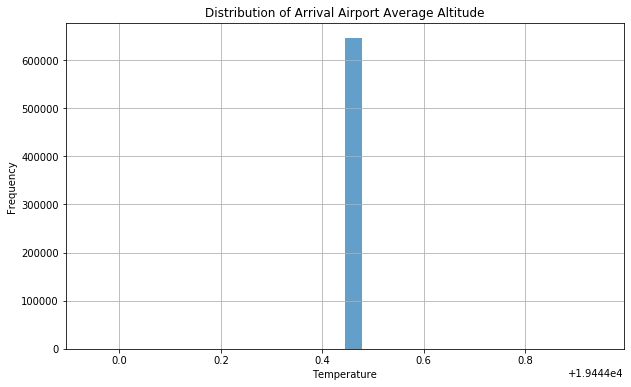

In [53]:
# arrival_airport_avg_altitude
pandas_df = flight.select("arrival_airport_avg_altitude").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(pandas_df['arrival_airport_avg_altitude'], bins=30, alpha=0.7)
plt.title('Distribution of Arrival Airport Average Altitude')
plt.xlabel('Altitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

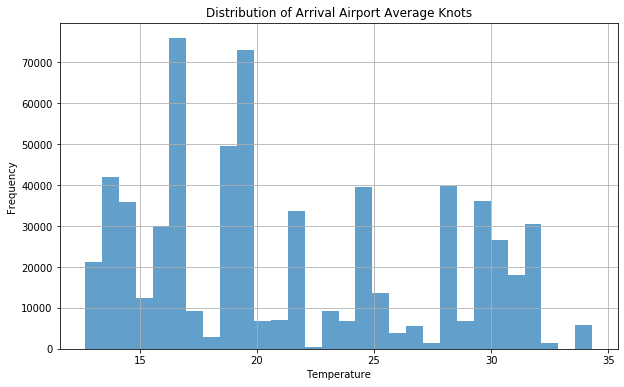

In [54]:
# arrival_airport_avg_knots
pandas_df = flight.select("arrival_airport_avg_knots").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(pandas_df['arrival_airport_avg_knots'], bins=30, alpha=0.7)
plt.title('Distribution of Arrival Airport Average Knots')
plt.xlabel('Knots')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

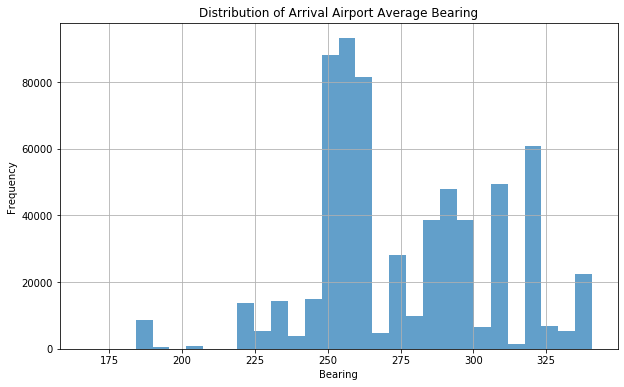

In [55]:
# arrival_airport_avg_bearing
pandas_df = flight.select("arrival_airport_avg_bearing").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(pandas_df['arrival_airport_avg_bearing'], bins=30, alpha=0.7)
plt.title('Distribution of Arrival Airport Average Bearing')
plt.xlabel('Bearing')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Encoding

In [ ]:
# We will focus on 10 columns 
# 1，departure_airport_code: string
# 2，arrival_airport_code: string
# 3，airline_code: string 
# 4，creator_code: string ？？
# 5, scheduled_aircraft_type: string 
# 6, icao_aircraft_type_actual: string
# 7, departure_airport: string 
# 8, arrival_airport: string 
# 9, aircraft_id: string 
# 10, legacy_route: string 


In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline  # Corrected import here
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType
import math

columns_to_encode = [
    "departure_airport_code", "arrival_airport_code", "airline_code", 
    "creator_code", "scheduled_aircraft_type", "icao_aircraft_type_actual",
    "departure_airport", "arrival_airport", "aircraft_id", "legacy_route"
]

# Create a StringIndexer for each column and collect them in a list
indexers = [
    StringIndexer(inputCol=column, outputCol=f"{column}_Index")
    for column in columns_to_encode
]

# Use a Pipeline to apply all indexers
pipeline = Pipeline(stages=indexers)
flight_indexed = pipeline.fit(flight).transform(flight)

# Define a function to convert index to binary string
def index_to_binary(index, length):
    binary_str = bin(int(index))[2:]  # Convert to binary string
    return binary_str.zfill(length)  # Pad with zeros

# Define a function to perform binary encoding
def apply_binary_encoding(df, column):
    max_index = df.agg({f"{column}_Index": "max"}).collect()[0][0]
    num_bits = math.ceil(math.log(max_index + 1, 2))
    
    udf_convert = F.udf(lambda x: index_to_binary(x, num_bits), StringType())
    df = df.withColumn(f"{column}_binary", udf_convert(F.col(f"{column}_Index")))
    
    for bit in range(num_bits):
        bit_col_name = f"{column}_bit_{bit}"
        df = df.withColumn(bit_col_name, F.substring(F.col(f"{column}_binary"), num_bits - bit, 1).cast(IntegerType()))
    
    return df, num_bits

# Apply binary encoding to each indexed column
for column in columns_to_encode:
    flight_indexed, _ = apply_binary_encoding(flight_indexed, column)

# Optionally drop intermediate columns
columns_to_drop = [f"{column}_Index" for column in columns_to_encode] + [f"{column}_binary" for column in columns_to_encode]
flight_encoded = flight_indexed.drop(*columns_to_drop)


+----------------------+------------------------------+-----------------------------+---------------------------+---------------------------------+------------------------------+-----------------------------+---------------------------+---------------------------------+------------------------------+-----------------------------+---------------------------+---------------------------------+--------------------+----------------------------+---------------------------+-------------------------+-------------------------------+----------------------------+---------------------------+-------------------------+-------------------------------+----------------------------+---------------------------+-------------------------+-------------------------------+------------+-------------+------------+------------------+--------------------+-----------------------+-------------------------+-----------------+---------------+-----------+--------------------+-----------------------------+--------------

In [83]:
from pyspark.sql.functions import expr, udf
from pyspark.sql.types import ArrayType, IntegerType

# Assuming your DataFrame is named df and the column with letters is named "letter"

# Step 1: Convert letters to numeric indices (Label Encoding)
flight_encoded = flight_encoded.withColumn("numeric_index", expr("ascii(lower(creator_code)) - ascii('a')"))

# Step 2: Convert numeric indices to binary form
def index_to_binary_array(value):
    # Assuming 5 bits for 26 letters
    binary_str = format(value, '05b')  
    return [int(bit) for bit in binary_str]

index_to_binary_array_udf = udf(index_to_binary_array, ArrayType(IntegerType()))

# Step 3: Apply UDF to create a binary representation column
flight_encoded = flight_encoded.withColumn("binary_encoded", index_to_binary_array_udf("numeric_index"))

# Step 4: Optionally, expand the binary_encoded array into separate columns
num_bits = 5
for bit in range(num_bits):
    flight_encoded = flight_encoded.withColumn(f"bit_{bit}", 
flight_encoded["binary_encoded"].getItem(bit))

flight_encoded.printSchema()


root
 |-- departure_airport_code: string (nullable = true)
 |-- departure_airport_avg_altitude: double (nullable = true)
 |-- departure_airport_avg_bearing: double (nullable = true)
 |-- departure_airport_avg_knots: double (nullable = true)
 |-- departure_airport_avg_temperature: double (nullable = true)
 |-- departure_airport_min_altitude: integer (nullable = true)
 |-- departure_airport_min_bearing: integer (nullable = true)
 |-- departure_airport_min_knots: integer (nullable = true)
 |-- departure_airport_min_temperature: integer (nullable = true)
 |-- departure_airport_max_altitude: integer (nullable = true)
 |-- departure_airport_max_bearing: integer (nullable = true)
 |-- departure_airport_max_knots: integer (nullable = true)
 |-- departure_airport_max_temperature: integer (nullable = true)
 |-- arrival_airport_code: string (nullable = true)
 |-- arrival_airport_avg_altitude: double (nullable = true)
 |-- arrival_airport_avg_bearing: double (nullable = true)
 |-- arrival_airport_

In [84]:
from pyspark.sql import SparkSession


columns_to_drop = ['binary_encoded', 'element', 'numeric_index']

flight_encoded = flight_encoded.drop(*columns_to_drop)

flight_encoded.printSchema()


root
 |-- departure_airport_code: string (nullable = true)
 |-- departure_airport_avg_altitude: double (nullable = true)
 |-- departure_airport_avg_bearing: double (nullable = true)
 |-- departure_airport_avg_knots: double (nullable = true)
 |-- departure_airport_avg_temperature: double (nullable = true)
 |-- departure_airport_min_altitude: integer (nullable = true)
 |-- departure_airport_min_bearing: integer (nullable = true)
 |-- departure_airport_min_knots: integer (nullable = true)
 |-- departure_airport_min_temperature: integer (nullable = true)
 |-- departure_airport_max_altitude: integer (nullable = true)
 |-- departure_airport_max_bearing: integer (nullable = true)
 |-- departure_airport_max_knots: integer (nullable = true)
 |-- departure_airport_max_temperature: integer (nullable = true)
 |-- arrival_airport_code: string (nullable = true)
 |-- arrival_airport_avg_altitude: double (nullable = true)
 |-- arrival_airport_avg_bearing: double (nullable = true)
 |-- arrival_airport_

In [85]:
# creator_code_numeric_index
columns_to_drop = ['creator_code_numeric_index']

flight_encoded = flight_encoded.drop(*columns_to_drop)

flight_encoded.printSchema()

root
 |-- departure_airport_code: string (nullable = true)
 |-- departure_airport_avg_altitude: double (nullable = true)
 |-- departure_airport_avg_bearing: double (nullable = true)
 |-- departure_airport_avg_knots: double (nullable = true)
 |-- departure_airport_avg_temperature: double (nullable = true)
 |-- departure_airport_min_altitude: integer (nullable = true)
 |-- departure_airport_min_bearing: integer (nullable = true)
 |-- departure_airport_min_knots: integer (nullable = true)
 |-- departure_airport_min_temperature: integer (nullable = true)
 |-- departure_airport_max_altitude: integer (nullable = true)
 |-- departure_airport_max_bearing: integer (nullable = true)
 |-- departure_airport_max_knots: integer (nullable = true)
 |-- departure_airport_max_temperature: integer (nullable = true)
 |-- arrival_airport_code: string (nullable = true)
 |-- arrival_airport_avg_altitude: double (nullable = true)
 |-- arrival_airport_avg_bearing: double (nullable = true)
 |-- arrival_airport_

In [86]:
columns_to_drop = ['departure_airport_code',
'arrival_airport_code',
'airline_code',
'creator_code',
'scheduled_aircraft_type',
'icao_aircraft_type_actual',
'departure_airport',
'arrival_airport',
'aircraft_id',
'legacy_route']

flight_encoded = flight_encoded.drop(*columns_to_drop)

flight_encoded.printSchema()

root
 |-- departure_airport_avg_altitude: double (nullable = true)
 |-- departure_airport_avg_bearing: double (nullable = true)
 |-- departure_airport_avg_knots: double (nullable = true)
 |-- departure_airport_avg_temperature: double (nullable = true)
 |-- departure_airport_min_altitude: integer (nullable = true)
 |-- departure_airport_min_bearing: integer (nullable = true)
 |-- departure_airport_min_knots: integer (nullable = true)
 |-- departure_airport_min_temperature: integer (nullable = true)
 |-- departure_airport_max_altitude: integer (nullable = true)
 |-- departure_airport_max_bearing: integer (nullable = true)
 |-- departure_airport_max_knots: integer (nullable = true)
 |-- departure_airport_max_temperature: integer (nullable = true)
 |-- arrival_airport_avg_altitude: double (nullable = true)
 |-- arrival_airport_avg_bearing: double (nullable = true)
 |-- arrival_airport_avg_knots: double (nullable = true)
 |-- arrival_airport_avg_temperature: double (nullable = true)
 |-- ar

In [87]:
flight_encoded_rdd = flight_encoded.cache() 